## Notebook to inspect data prior to pre-processing

In [1]:
import GEOparse as geo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import sys

from tqdm import tqdm
from preprocess import *

preprocess imported
module name : preprocess module package: 


***
# Inspecting sci-CAR Dataset
***

In [2]:
''' List the needed files for the analysis '''
sci_car_data_path = os.path.join(os.getcwd(), 'data', 'sci-CAR', 'GSE117089_RAW')
sci_car_files = []
for file in sorted(os.listdir(sci_car_data_path)):
    if not file.endswith('.gz') and not file == '.DS_Store':
        sci_car_files.append(file)

In [3]:
sci_car_files

['GSM3271040_RNA_sciCAR_A549_cell.txt',
 'GSM3271040_RNA_sciCAR_A549_gene.txt',
 'GSM3271040_RNA_sciCAR_A549_gene_count.txt',
 'GSM3271041_ATAC_sciCAR_A549_cell.txt',
 'GSM3271041_ATAC_sciCAR_A549_peak.txt',
 'GSM3271041_ATAC_sciCAR_A549_peak_count.txt',
 'GSM3271042_RNA_only_A549_cell.txt',
 'GSM3271042_RNA_only_A549_gene.txt',
 'GSM3271042_RNA_only_A549_gene_count.txt',
 'GSM3271043_ATAC_only_A549_cell.txt',
 'GSM3271043_ATAC_only_A549_peak.txt',
 'GSM3271043_ATAC_only_A549_peak_count.txt',
 'GSM3271044_RNA_mouse_kidney_cell.txt',
 'GSM3271044_RNA_mouse_kidney_gene.txt',
 'GSM3271044_RNA_mouse_kidney_gene_count.txt',
 'GSM3271045_ATAC_mouse_kidney_cell.txt',
 'GSM3271045_ATAC_mouse_kidney_peak.txt',
 'GSM3271045_ATAC_mouse_kidney_peak_count.txt',
 'GSM3271045_Peak_CellType_signal.csv',
 'GSM3271045_da.sites.csv']

***
### Start with DEX-treated A549 cells


#### File structure:
- **RNA_sciCAR**:
    - cell sep=',' (6093, 4), ['sample', 'cell_name', 'experiment', 'treatment_time']
    - gene sep=',' ((113153, 3), ['gene_id', 'gene_type', 'gene_short_name']
    - gene_count sep=' ' (9251102, 5) ['%%MatrixMarket', 'matrix', 'coordinate', 'integer', 'general']
- **ATAC_sciCAR**: 
    - cell sep=','  (6085, 4), Index(['sample', 'source', 'group', 'experiment']
    - peak sep=','  (189603, 5), Index(['id', 'peak', 'chr', 'start', 'end']
    - peak_count sep=' ' (1950460, 5), Index(['%%MatrixMarket', 'matrix', 'coordinate', 'real', 'general']
- **RNA Only**:
    - cell sep=','  (1873, 4), Index(['sample', 'cell_name', 'experiment', 'treatment_time']
    - gene sep=','  (113153, 3), Index(['gene_id', 'gene_type', 'gene_short_name']
    - gene count sep=' '    (3205848, 5), Index(['%%MatrixMarket', 'matrix', 'coordinate', 'integer', 'general']
- **ATAC Only**:
    - cell sep=','  (2006, 4), Index(['sample', 'source', 'group', 'experiment']
    - peak sep=','   (189603, 5), Index(['id', 'peak', 'chr', 'start', 'end']
    - peak_count sep=','   (6280913, 5),  Index(['%%MatrixMarket', 'matrix', 'coordinate', 'real', 'general']

In [4]:
''' Trying loading just one file '''
ix = 11
file_path = os.path.join(sci_car_data_path, sci_car_files[ix])
print(os.path.split(file_path)[1])
df = pd.read_csv(file_path, sep=' ', header=0) #read df

GSM3271043_ATAC_only_A549_peak_count.txt


In [5]:
df.shape, df.columns

((6280913, 5),
 Index(['%%MatrixMarket', 'matrix', 'coordinate', 'real', 'general'], dtype='object'))

In [6]:
df

,%%MatrixMarket,matrix,coordinate,real,general
0,189603,2006,6280912.0,NaN,NaN
1,58,1,50.0,NaN,NaN
2,61,1,97.0,NaN,NaN
3,146,1,2.0,NaN,NaN
4,165,1,1.0,NaN,NaN
...,...,...,...,...,...
6280908,189128,2006,2.0,NaN,NaN
6280909,189131,2006,1.0,NaN,NaN
6280910,189174,2006,1.0,NaN,NaN
6280911,189198,2006,1.0,NaN,NaN


In [7]:
''' Load in all files as DataFrames, save in dictionary '''
sci_car_DEX_dict = {}
for f in tqdm(sci_car_files):
    if 'A549' in f:
        file_path = os.path.join(sci_car_data_path, f)  # get path of file 
#         print(file_path)
        s = f[:-4].split('_') # split data, remove .txt
        mod_name = f'{s[1]}_{s[2]}' # get modality name
        if 'count' in s: sep = ' '
        else: sep = ','
        df = pd.read_csv(file_path, sep=sep, header=0) #read df
        # add to dictionary
        if mod_name in sci_car_DEX_dict:
            sci_car_DEX_dict[mod_name][s[-1]] = df
        else:
            sci_car_DEX_dict[mod_name] = {s[-1]:df}
# data = pd.read_csv('output_list.txt', sep=" ", header=None)
print('Data loaded')

 15%|█▌        | 3/20 [00:01<00:08,  1.91it/s]/Users/tjamesso/miniconda3/envs/broad/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

Data loaded


### RNA-sciCAR

#### Dataset description:
- cell 
    - 6093 unique sample names: e.g. sci-RNA-A-001.CGCCAGGCAT
    - cell_name look like cell types
        - A549     4277
        - 3T3       868
        - 293T      812
        - mixed     136
    - experiment is always 'coassay'
    - treatment_time: 
        - 3.0 hrs:    1609
        - 1.0 hrs:    1491
        - 0.0 hrs:    1177
        - NaN:    1816  (**all of these are not A549 cells, so we'll omit**) 
- gene
    - Has info on gene names, gene types, and their gene_ids
    - Good reference for getting the name of a gene
    - MatrixMarket corresponds to geneID (113153 is the max and there are this many possible genes/loci)
- gene count
    - integer and general columns only have NaNs. Not sure why they're there
    - matrix column has 6093 entries and there are 6093 cells! Looks like we can concatenate along these axes

In [8]:
''' Make dataframe for RNA-sciCAR'''
# Inspect the RNA-sciCAR data
sci_RNA_dict = sci_car_DEX_dict['RNA_sciCAR']

cell, counts = sci_RNA_dict['cell'], sci_RNA_dict['count']

# add matrix column to gene counts
matrix_col = pd.RangeIndex(start=1, stop=6094)
cell['matrix'] = matrix_col

# Join cells and genes 
sci_RNA = pd.merge(cell, counts)

# Only select A549 cells 
sci_RNA = sci_RNA[sci_RNA['cell_name'] == 'A549']
sci_RNA = sci_RNA.drop(['integer', 'general'], axis=1)

# Now add gene_ids
sci_RNA = sci_RNA.rename(columns={'%%MatrixMarket': 'gene_ix'})
genes_dir = sci_car_DEX_dict['RNA_sciCAR']['gene']
genes_dir['gene_ix'] = pd.RangeIndex(start=1, stop=113154)
sci_RNA = pd.merge(sci_RNA, genes_dir)

In [9]:
sci_RNA

,sample,cell_name,experiment,treatment_time,matrix,gene_ix,coordinate,gene_id,gene_type,gene_short_name
0,sci-RNA-A-001.AAGTACGTTA,A549,coassay,3.0,2,40,1,ENSG00000248527.1,pseudogene,MTATP6P1
1,sci-RNA-A-001.TTCTATAGAG,A549,coassay,1.0,6,40,1,ENSG00000248527.1,pseudogene,MTATP6P1
2,sci-RNA-A-002.AATCCGGTCA,A549,coassay,1.0,22,40,2,ENSG00000248527.1,pseudogene,MTATP6P1
3,sci-RNA-A-002.CTGAAGAGAC,A549,coassay,1.0,23,40,1,ENSG00000248527.1,pseudogene,MTATP6P1
4,sci-RNA-A-002.TTCGCTGCCT,A549,coassay,1.0,24,40,1,ENSG00000248527.1,pseudogene,MTATP6P1
...,...,...,...,...,...,...,...,...,...,...
6314385,sci-RNA-E-096.ACTCTACTGG,A549,coassay,1.0,6092,40326,1,ENSG00000260760.1,lincRNA,PWRN3
6314386,sci-RNA-E-096.ACTCTACTGG,A549,coassay,1.0,6092,90949,1,ENSMUSG00000111190.1,polymorphic_pseudogene,Olfr947-ps1
6314387,sci-RNA-E-096.CCGCGCAGGT,A549,coassay,1.0,6093,113153,9251101,ENSMUSG00000064372.1,Mt_tRNA,mt-Tp
6314388,sci-RNA-E-096.CCGCGCAGGT,A549,coassay,1.0,6093,53331,1,ENSG00000223608.1,sense_intronic,DSCR4-IT1


### ATAC-sciCAR

#### Dataset description:
- cell 
    - 6093 unique sample names: e.g. sci-RNA-A-001.CGCCAGGCAT
    - cell_name look like cell types
        - A549     4277
        - 3T3       868
        - 293T      812
        - mixed     136
    - experiment is always 'coassay'
    - treatment_time: 
        - 3.0 hrs:    1609
        - 1.0 hrs:    1491
        - 0.0 hrs:    1177
        - NaN:    1816  (**all of these are not A549 cells, so we'll omit**) 
- gene
    - Has info on gene names, gene types, and their gene_ids
    - Good reference for getting the name of a gene
    - MatrixMarket corresponds to geneID (113153 is the max and there are this many possible genes/loci)
- gene count
    - integer and general columns only have NaNs. Not sure why they're there
    - matrix column has 6093 entries and there are 6093 cells! Looks like we can concatenate along these axes

In [10]:
''' Make dataframe for ATAC-sciCAR'''
sci_ATAC_dict = sci_car_DEX_dict['ATAC_sciCAR']

peak, count = sci_ATAC_dict['peak'], sci_ATAC_dict['count']

# count joins with cell using matrix and id
cell = sci_ATAC_dict['cell']

cell['matrix'] = pd.RangeIndex(start=1, stop=6086)
if 'mat' in cell.columns:
    cell = cell.drop('mat',axis=1)

# merge cells with counts
sci_ATAC = pd.merge(cell, count)

# merge with peaks
sci_ATAC = pd.merge(sci_ATAC, peak, left_on='%%MatrixMarket', right_on='id')
sci_ATAC = sci_ATAC[sci_ATAC['group'] != '293T_3T3']
sci_ATAC = sci_ATAC.drop(['real', 'general'],axis=1)

# split columns, drop group
sci_ATAC = split_column(sci_ATAC, col_to_split='group', col1_name='cell_name', col2_name='treatment_time', col1_ix=3, col2_ix=4)
if 'group' in sci_ATAC.columns:
    sci_ATAC = sci_ATAC.drop('group', axis=1) #drop if there

In [11]:
sci_ATAC

,sample,source,cell_name,treatment_time,experiment,matrix,%%MatrixMarket,coordinate,id,peak,chr,start,end
1,sci-RNA-A-071.GCGGAGTCGA,Human,A549,3h,co_assay,2,173487,8.0,173487,GL000220.1-117507-120143,GL000220.1,117507,120143
2,sci-RNA-A-071.TTGCAGCATT,Human,A549,1h,co_assay,3,173487,6.0,173487,GL000220.1-117507-120143,GL000220.1,117507,120143
3,sci-RNA-A-071.GCGGCCAATC,Human,A549,3h,co_assay,5,173487,7.0,173487,GL000220.1-117507-120143,GL000220.1,117507,120143
4,sci-RNA-A-071.CTGAAGAGAC,Human,A549,1h,co_assay,6,173487,16.0,173487,GL000220.1-117507-120143,GL000220.1,117507,120143
5,sci-RNA-A-071.GGCTGCCTTA,Human,A549,0h,co_assay,7,173487,258.0,173487,GL000220.1-117507-120143,GL000220.1,117507,120143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950455,sci-RNA-E-022.ACTCGACGCC,Human,A549,0h,co_assay,6085,148468,2.0,148468,7-3439449-3439795,7,3439449,3439795
1950456,sci-RNA-E-022.ACTCGACGCC,Human,A549,0h,co_assay,6085,155138,2.0,155138,7-122743643-122744143,7,122743643,122744143
1950457,sci-RNA-E-022.ACTCGACGCC,Human,A549,0h,co_assay,6085,155571,2.0,155571,7-130066554-130067320,7,130066554,130067320
1950458,sci-RNA-E-022.ACTCGACGCC,Human,A549,0h,co_assay,6085,158814,1.0,158814,8-20040626-20041217,8,20040626,20041217


In [12]:
ATAC_samples = set(sci_ATAC['sample'].unique())
RNA_samples = set(sci_RNA['sample'].unique())

In [13]:
''' Check number of samples in each '''
print(len(ATAC_samples), len(RNA_samples))
print(f'{len(RNA_samples.intersection(ATAC_samples))} samples are common btwn ATAC and RNA-seq')

4258 4277
3260 samples are common btwn ATAC and RNA-seq


***
### Now look at Mouse Kidney Cells (sci-CAR)

In [14]:
sci_car_files

['GSM3271040_RNA_sciCAR_A549_cell.txt',
 'GSM3271040_RNA_sciCAR_A549_gene.txt',
 'GSM3271040_RNA_sciCAR_A549_gene_count.txt',
 'GSM3271041_ATAC_sciCAR_A549_cell.txt',
 'GSM3271041_ATAC_sciCAR_A549_peak.txt',
 'GSM3271041_ATAC_sciCAR_A549_peak_count.txt',
 'GSM3271042_RNA_only_A549_cell.txt',
 'GSM3271042_RNA_only_A549_gene.txt',
 'GSM3271042_RNA_only_A549_gene_count.txt',
 'GSM3271043_ATAC_only_A549_cell.txt',
 'GSM3271043_ATAC_only_A549_peak.txt',
 'GSM3271043_ATAC_only_A549_peak_count.txt',
 'GSM3271044_RNA_mouse_kidney_cell.txt',
 'GSM3271044_RNA_mouse_kidney_gene.txt',
 'GSM3271044_RNA_mouse_kidney_gene_count.txt',
 'GSM3271045_ATAC_mouse_kidney_cell.txt',
 'GSM3271045_ATAC_mouse_kidney_peak.txt',
 'GSM3271045_ATAC_mouse_kidney_peak_count.txt',
 'GSM3271045_Peak_CellType_signal.csv',
 'GSM3271045_da.sites.csv']

In [15]:
''' Load in all files as DataFrames, save in dictionary '''
sci_car_kidney_dict = {}
for f in tqdm(sci_car_files):
    if 'mouse' in f: 
        file_path = os.path.join(sci_car_data_path, f)  # get path of file 
#         print(file_path)
        s = f[:-4].split('_') # split data, remove .txt
        mod_name = f'{s[1]}_{s[2]}' # get modality name
        if 'count' in s: sep = ' '
        else: sep = ','
        df = pd.read_csv(file_path, sep=sep, header=0) #read df
        # add to dictionary
        if mod_name in sci_car_kidney_dict:
            sci_car_kidney_dict[mod_name][s[-1]] = df
        else:
            sci_car_kidney_dict[mod_name] = {s[-1]:df}
# data = pd.read_csv('output_list.txt', sep=" ", header=None)
print('Data loaded')

100%|██████████| 20/20 [00:03<00:00,  6.35it/s]

Data loaded


In [16]:
k_cell = sci_car_kidney_dict['RNA_mouse']['cell']

In [25]:
k_cell

,sample,source,replicate,experiment,tsne_1,tsne_2,cell_name
0,coRNA-RNA-plate1-001.TCGGCGTCGT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
1,coRNA-RNA-plate1-001.CATGACTCAA,Mouse,Replicate 1,coassay,2.808426,-45.948924,Loop of Henle cells
2,coRNA-RNA-plate1-001.CGCCAGGCAT,Mouse,Replicate 1,coassay,-4.660380,-41.004499,Loop of Henle cells
3,coRNA-RNA-plate1-001.CTGGTTGGTT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
4,coRNA-RNA-plate1-001.CCAGGCTCTT,Mouse,Replicate 2,coassay,10.309332,11.143745,Proximal tubule S1/S2 cells
...,...,...,...,...,...,...,...
13888,coRNA-RNA-plate8-096.GCTCGAATCA,Mouse,Replicate 2,coassay,34.541703,-6.368314,Proximal tubule S3 cells (type 2)
13889,coRNA-RNA-plate8-096.GACCAATGCG,Mouse,Replicate 1,coassay,-3.729165,30.804146,Proximal tubule S1/S2 cells
13890,coRNA-RNA-plate8-096.AATACCAGTT,Mouse,Replicate 1,coassay,-14.379572,33.444072,Proximal tubule S1/S2 cells
13891,coRNA-RNA-plate8-096.TAGAATAGCC,Mouse,Replicate 2,coassay,NaN,NaN,NaN


In [17]:
import seaborn as sns

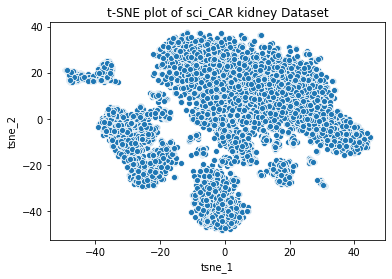

In [18]:
fig, axs = plt.subplots(1)
sns.scatterplot(k_cell['tsne_1'], k_cell['tsne_2'],ax=axs);
axs.set_title('t-SNE plot of sci_CAR kidney Dataset');

**Conclusion:** This dataset requires identifying cell types based on which cluster they fall into on a tsne plot. Because the labels are not clearly defined, we'll avoid using this one

***
# CITE-Seq Dataset

In [19]:
cite_seq_data_path = os.path.join(os.getcwd(), 'data', 'CITE-seq')
cite_seq_files = []
for file in sorted(os.listdir(cite_seq_data_path)):
    if not file.endswith('.gz') and not file == '.DS_Store':
        cite_seq_files.append(file)

In [20]:
cite_seq_files

['GSE100866_CBMC_8K_13AB_10X-ADT_clr-transformed.csv',
 'GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv',
 'GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv',
 'GSE100866_CD8_merged-ADT_clr-transformed.csv',
 'GSE100866_CD8_merged-ADT_umi.csv',
 'GSE100866_CD8_merged-RNA_umi.csv',
 'GSE100866_PBMC_vs_flow_10X-ADT_clr-transformed.csv',
 'GSE100866_PBMC_vs_flow_10X-ADT_umi.csv',
 'GSE100866_PBMC_vs_flow_10X-RNA_umi.csv']

In [21]:
''' Load cite seq datasets, put into list '''
load_cite_seq = True
if load_cite_seq:
    cite_seq_dfs = []
    for file in tqdm(cite_seq_files):
        cite_seq_dfs.append(pd.read_csv(os.path.join(cite_seq_data_path, file)))

100%|██████████| 9/9 [01:38<00:00, 10.92s/it]


In [22]:
''' Checking to see if indices match'''
len(set(cite_seq_dfs[2]) & set(cite_seq_dfs[0])), len(set(cite_seq_dfs[2]))

(8618, 8618)

In [23]:
''' Put datasets into a nice dictionary '''
cite_seq_dict = {}
for ix, file in enumerate(cite_seq_files):
    s = file.split('_')
    print(s)
    cell_type = s[1]
    mod = s[-2].split('-')[1]
    if 'clr' in s[-1]:
        mod += '-clrT'
    if cell_type in cite_seq_dict:
        cite_seq_dict[cell_type][mod] = cite_seq_dfs[ix]
    else:
        cite_seq_dict[cell_type] = {mod: cite_seq_dfs[ix]}

['GSE100866', 'CBMC', '8K', '13AB', '10X-ADT', 'clr-transformed.csv']
['GSE100866', 'CBMC', '8K', '13AB', '10X-ADT', 'umi.csv']
['GSE100866', 'CBMC', '8K', '13AB', '10X-RNA', 'umi.csv']
['GSE100866', 'CD8', 'merged-ADT', 'clr-transformed.csv']
['GSE100866', 'CD8', 'merged-ADT', 'umi.csv']
['GSE100866', 'CD8', 'merged-RNA', 'umi.csv']
['GSE100866', 'PBMC', 'vs', 'flow', '10X-ADT', 'clr-transformed.csv']
['GSE100866', 'PBMC', 'vs', 'flow', '10X-ADT', 'umi.csv']
['GSE100866', 'PBMC', 'vs', 'flow', '10X-RNA', 'umi.csv']


In [28]:
cite_seq_dict['CBMC']['RNA']

,Unnamed: 0,CTGTTTACACCGCTAG,CTCTACGGTGTGGCTC,AGCAGCCAGGCTCATT,GAATAAGAGATCCCAT,GTGCATAGTCATGCAT,TACACGACACATCCGG,TCATTTGGTGTGAAAT,GGGCACTGTGAAGGCT,AACACGTCATTAACCG,...,GACGCGTGTAGAAAGG,AGCGTCGTCCCAAGTA,AGCGTCGAGTCAAGGC,GTCGGGTAGTAGCCGA,GTCGGGTAGTTCGCAT,TTGCCGTGTAGATTAG,GGCGTGTAGTGTACTC,CGTATGCCGTCTTCTG,TACACGACGCTCTTCC,ACACGACGCTCTTCCG
0,ERCC_ERCC-00104,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HUMAN_A1BG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HUMAN_A1BG-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HUMAN_A1CF,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HUMAN_A2M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36275,MOUSE_mt-Tt,1,0,1,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
36276,MOUSE_mt-Tw,1,0,2,1,0,2,0,0,2,...,0,0,0,0,0,0,0,0,0,0
36277,MOUSE_n-R5s200,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36278,MOUSE_n-R5s25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
